In [2]:
# Kết nối Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:

!pip install patool
import patoolib

# Giải nén FMD_DATASET.rar từ Google Drive
zip_path = '/content/drive/MyDrive/Master/MachineVision/FaceMaskDetection/FMD_Dataset.rar'
extract_path = '/content/'  # Đường dẫn để giải nén

patoolib.extract_archive(zip_path, outdir=extract_path) # using patool to extract rar file


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.3/86.3 kB 7.0 MB/s eta 0:00:00


INFO patool: Extracting /content/drive/MyDrive/Master/MachineVision/FaceMaskDetection/FMD_Dataset.rar ...
INFO:patool:Extracting /content/drive/MyDrive/Master/MachineVision/FaceMaskDetection/FMD_Dataset.rar ...
INFO patool: running /usr/bin/unrar x -kb -or -- /content/drive/MyDrive/Master/MachineVision/FaceMaskDetection/FMD_Dataset.rar
INFO:patool:running /usr/bin/unrar x -kb -or -- /content/drive/MyDrive/Master/MachineVision/FaceMaskDetection/FMD_Dataset.rar
INFO patool: ... /content/drive/MyDrive/Master/MachineVision/FaceMaskDetection/FMD_Dataset.rar extracted to `/content/'.
INFO:patool:... /content/drive/MyDrive/Master/MachineVision/FaceMaskDetection/FMD_Dataset.rar extracted to `/content/'.


'/content/'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [4]:
# 📌 1. Cài đặt thư viện (nếu chưa có)
!pip install tensorflow matplotlib scikit-learn opencv-python --quiet

In [5]:
# 📌 2. Import thư viện
import os, shutil, random
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import cv2
import tensorflow as tf
from tqdm import tqdm

In [6]:
import os
import random
import shutil
from glob import glob
import hashlib

DATASET_DIR = "/content/FMD_Dataset"
TEST_DIR = "/content/FMD_TEST"
TEST_RATIO = 0.2

def get_file_hash(filepath):
    """Tính hash của file để phát hiện file trùng nội dung"""
    with open(filepath, 'rb') as f:
        return hashlib.md5(f.read()).hexdigest()

def create_test_set():
    if os.path.exists(TEST_DIR):
        print("📁 FMD_TEST đã tồn tại, bỏ qua bước chia tập test.")
        return

    os.makedirs(TEST_DIR, exist_ok=True)
    known_hashes = set()
    known_logical_names = set()

    for class_name in os.listdir(DATASET_DIR):
        class_path = os.path.join(DATASET_DIR, class_name)
        if not os.path.isdir(class_path):
            continue

        # Lấy ảnh trong các folder con (đệ quy)
        image_paths = glob(os.path.join(class_path, '**', '*.[jJpP]*[nNgG]'), recursive=True)
        image_paths = list(set(image_paths))  # Loại trùng đường dẫn nếu có

        # Loại bỏ ảnh trùng logic: "1.jpg", "1(1).jpg", "1(2).jpg"
        filtered_images = []
        logical_names = set()

        for path in image_paths:
            basename = os.path.basename(path)
            logical_name = basename.split('(')[0]  # Ví dụ: "1(1).jpg" → "1.jpg"
            if logical_name not in logical_names:
                logical_names.add(logical_name)
                # Optional: kiểm tra trùng nội dung
                file_hash = get_file_hash(path)
                if file_hash not in known_hashes:
                    known_hashes.add(file_hash)
                    known_logical_names.add(logical_name)
                    filtered_images.append(path)

        num_test = int(len(filtered_images) * TEST_RATIO)
        test_images = random.sample(filtered_images, num_test)

        dest_class_dir = os.path.join(TEST_DIR, class_name)
        os.makedirs(dest_class_dir, exist_ok=True)

        for img_path in test_images:
            dest_path = os.path.join(dest_class_dir, os.path.basename(img_path))
            shutil.move(img_path, dest_path)

        print(f"✅ Đã di chuyển {len(test_images)} ảnh KHÔNG trùng của lớp '{class_name}' vào FMD_TEST.")

create_test_set()


✅ Đã di chuyển 499 ảnh KHÔNG trùng của lớp 'incorrect_mask' vào FMD_TEST.
✅ Đã di chuyển 794 ảnh KHÔNG trùng của lớp 'with_mask' vào FMD_TEST.
✅ Đã di chuyển 661 ảnh KHÔNG trùng của lớp 'without_mask' vào FMD_TEST.


In [7]:
# 📌 4. Thiết lập tham số
IMG_SIZE = 128
BATCH_SIZE = 128
EPOCHS = 10

# 📌 5. Tạo ImageDataGenerator cho train/val
train_val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

train_generator = train_val_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = train_val_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 6838 images belonging to 3 classes.
Found 1708 images belonging to 3 classes.


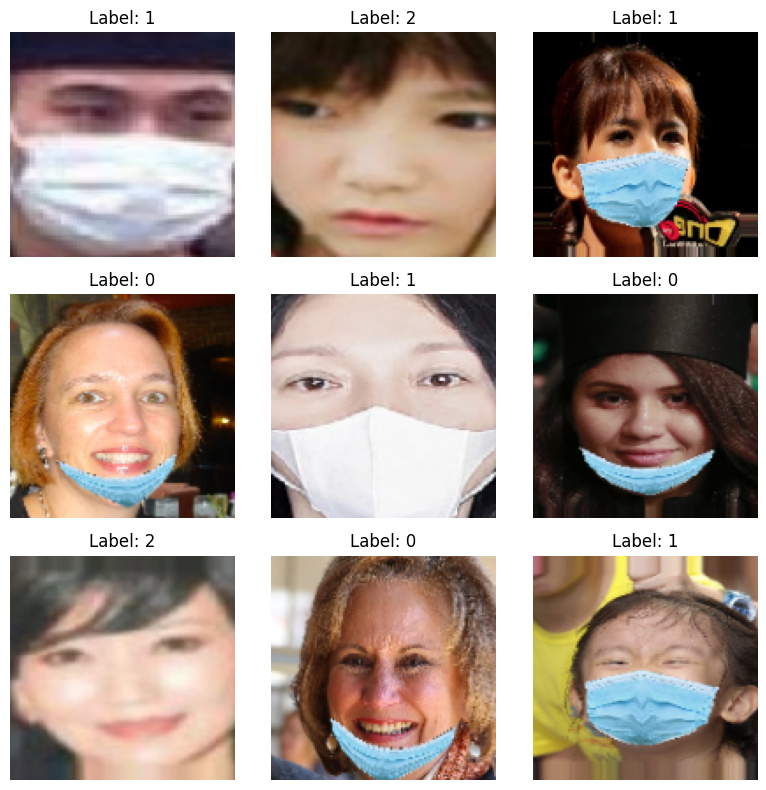

In [8]:
# Display sample image from training set
x_batch, y_batch = next(train_generator)
plt.figure(figsize=(8, 8))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_batch[i])
    plt.title(f"Label: {np.argmax(y_batch[i])}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [9]:
for class_name in os.listdir(DATASET_DIR):
       class_dir = os.path.join(DATASET_DIR, class_name)
       if os.path.isdir(class_dir):
           image_count = len([f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))])
           print(f"Lớp '{class_name}': {image_count} ảnh")

Lớp 'incorrect_mask': 2001 ảnh
Lớp 'with_mask': 3206 ảnh
Lớp 'without_mask': 3339 ảnh


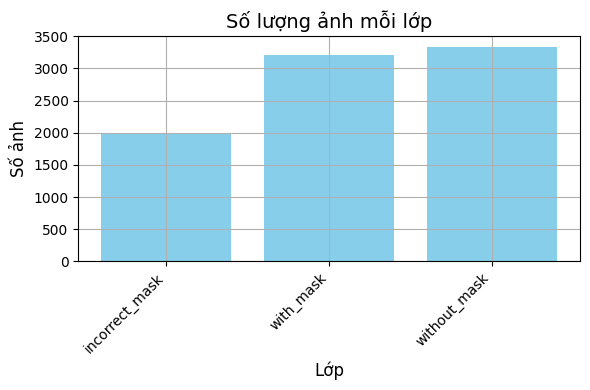

In [10]:
import os
from collections import defaultdict
import matplotlib.pyplot as plt

DATASET_DIR = "/content/FMD_Dataset"  # Đường dẫn đến thư mục chứa dữ liệu

class_counts = defaultdict(int)

for class_name in os.listdir(DATASET_DIR):
    class_dir = os.path.join(DATASET_DIR, class_name)
    if os.path.isdir(class_dir):
        # Đếm trực tiếp tất cả các file ảnh trong thư mục lớp
        image_count = len([f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        class_counts[class_name] = image_count

# Vẽ biểu đồ
plt.figure(figsize=(6, 4))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title("Số lượng ảnh mỗi lớp", fontsize=14)
plt.xlabel("Lớp", fontsize=12)
plt.ylabel("Số ảnh", fontsize=12)
plt.xticks(rotation=45, ha='right')  # Xoay nhãn trục x nếu cần
plt.tight_layout()  # Điều chỉnh bố cục để tránh chồng chéo
plt.grid(True)
plt.show()

In [11]:
# 📌 6. Huấn luyện mô hình MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(3, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
# Print model structure
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,261,827 (8.63 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [13]:
# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [15]:
import tensorflow as tf
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
from tensorflow.python.profiler import model_analyzer
from tensorflow.python.profiler.option_builder import ProfileOptionBuilder

# Tạo một concrete function từ model
input_shape = (1, 128, 128, 3)
@tf.function
def model_func(inputs):
    return model(inputs)

concrete_func = model_func.get_concrete_function(tf.TensorSpec(input_shape, tf.float32))

# Chuyển model sang dạng frozen graph
frozen_func = convert_variables_to_constants_v2(concrete_func)
graph_def = frozen_func.graph.as_graph_def()

# Tính FLOPs
with tf.Graph().as_default() as graph:
    tf.import_graph_def(graph_def, name='')

    run_meta = tf.compat.v1.RunMetadata()
    opts = ProfileOptionBuilder.float_operation()

    flops = model_analyzer.profile(graph=graph, run_meta=run_meta, options=opts)
    print(f"🔢 Tổng số FLOPs: {flops.total_float_ops:,}")
    print(f"✨ Tương đương: {flops.total_float_ops / 1e9:.2f} GFLOPs")


Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


🔢 Tổng số FLOPs: 200,150,482
✨ Tương đương: 0.20 GFLOPs


In [16]:
# Train

from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_cb = ModelCheckpoint("best_model.keras", save_best_only=True, monitor='val_accuracy', mode='max')

history = model.fit(train_generator, validation_data=val_generator, epochs=EPOCHS, callbacks=[checkpoint_cb])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 200s 4s/step - accuracy: 0.7842 - loss: 0.5396 - val_accuracy: 0.9532 - val_loss: 0.1312
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 188s 3s/step - accuracy: 0.9631 - loss: 0.1211 - val_accuracy: 0.9619 - val_loss: 0.1113
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 188s 4s/step - accuracy: 0.9724 - loss: 0.0907 - val_accuracy: 0.9631 - val_loss: 0.1044
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 187s 3s/step - accuracy: 0.9769 - loss: 0.0760 - val_accuracy: 0.9737 - val_loss: 0.0817
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - accuracy: 0.9802 - loss: 0.0633 - val_accuracy: 0.9725 - val_loss: 0.0839
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 207s 4s/step - accuracy: 0.9855 - loss: 0.0489 - val_accuracy: 0.9807 - val_loss: 0.0647
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 187s 3s/step - accuracy: 0.9858 - loss: 0.0505 - val_accuracy: 0.9701 - val_loss: 0.0855
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 192s 4s/step - accuracy: 0.9848 - loss: 0.0488 - val_accuracy: 0.9789 - v

In [17]:
# 📌 7. Lưu mô hình
model.save("/content/mask_classifier_mnv2.keras")
print("💾 Đã lưu mô hình thành công!")

💾 Đã lưu mô hình thành công!


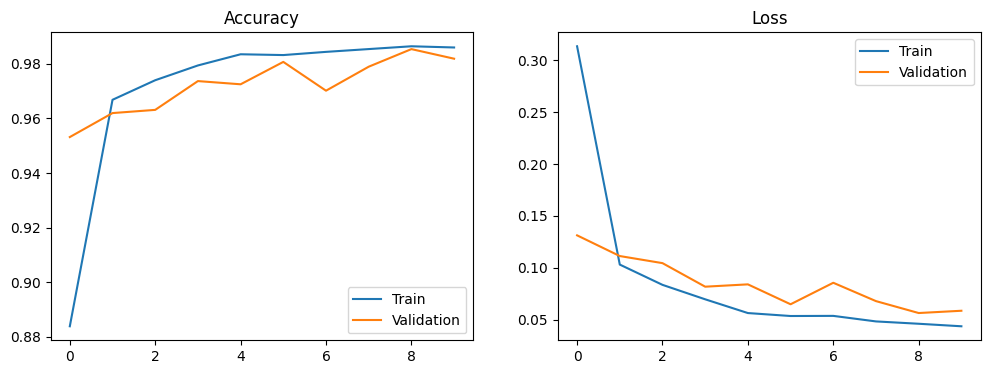

In [18]:
# 📌 8. Hiển thị đồ thị Accuracy & Loss
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.legend()
plt.show()

In [19]:
# 📌 9. Đánh giá trên tập test (FMD_TEST)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

test_loss, test_accuracy = model.evaluate(test_generator)
print(f"🎯 Độ chính xác trên tập test: {test_accuracy * 100:.2f}%")
print(f"📉 Loss trên tập test: {test_loss:.4f}")

Found 1954 images belonging to 3 classes.
1148/1954 ━━━━━━━━━━━━━━━━━━━━ 23s 29ms/step

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1954/1954 ━━━━━━━━━━━━━━━━━━━━ 52s 26ms/step
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 48s 25ms/step - accuracy: 0.9809 - loss: 0.0582
🎯 Độ chính xác trên tập test: 98.62%
📉 Loss trên tập test: 0.0444



📊 Classification Report:
                precision    recall  f1-score   support

incorrect_mask       0.98      0.97      0.98       499
     with_mask       0.98      1.00      0.99       794
  without_mask       0.99      0.98      0.99       661

      accuracy                           0.99      1954
     macro avg       0.99      0.98      0.99      1954
  weighted avg       0.99      0.99      0.99      1954



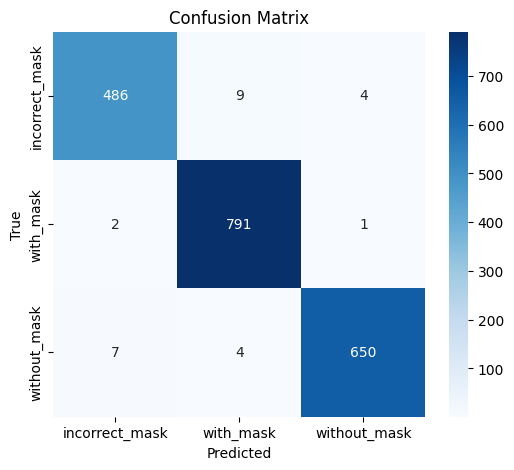

In [20]:
# 📌 10. Classification Report & Confusion Matrix
print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

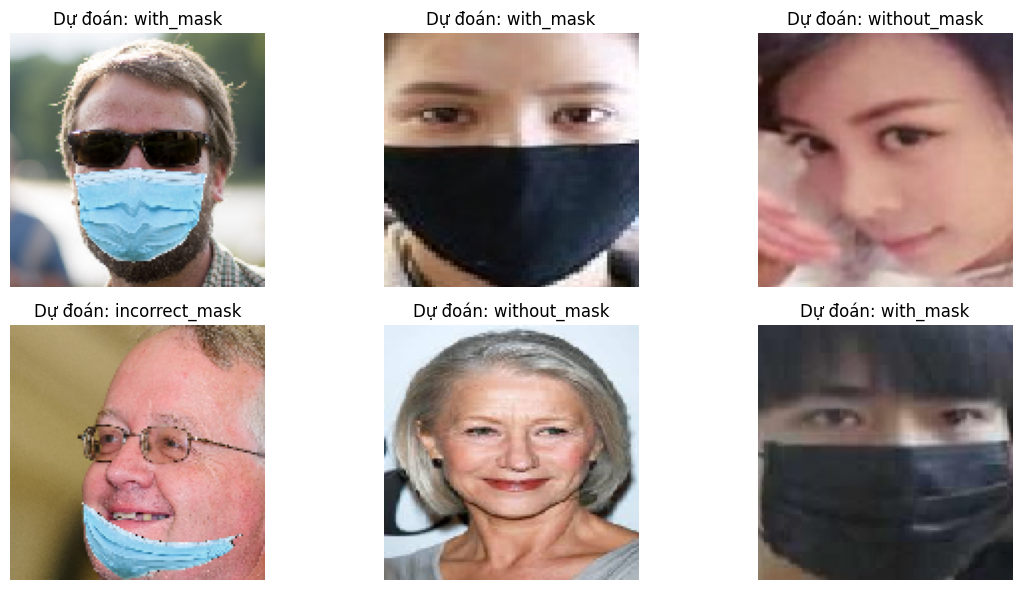

In [21]:
# 📌 11. Hiển thị vài ảnh mẫu dự đoán
sample_paths = random.sample(test_generator.filepaths, 6)

plt.figure(figsize=(12, 6))
for i, img_path in enumerate(sample_paths):
    # Load và xử lý ảnh
    img = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = img_to_array(img) / 255.0
    prediction = model.predict(np.expand_dims(img_array, axis=0), verbose=0)
    pred_label = class_labels[np.argmax(prediction)]

    # Hiển thị ảnh và nhãn dự đoán
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Dự đoán: {pred_label}")
plt.tight_layout()
plt.show()

In [22]:
# Tải mô hình về
from google.colab import files
files.download("/content/best_model.keras")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
'''
import shutil
import os

DATASET_DIR = "/content/FMD_DATASET"
TEST_DIR = "/content/FMD_TEST"

def delete_dataset_and_test():
    if os.path.exists(DATASET_DIR):
        shutil.rmtree(DATASET_DIR)
        print("🗑️ Đã xóa toàn bộ thư mục FMD_DATASET.")

    if os.path.exists(TEST_DIR):
        shutil.rmtree(TEST_DIR)
        print("🗑️ Đã xóa toàn bộ thư mục FMD_TEST.")

delete_dataset_and_test()
'''